In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve  

# Model definition
class FitzHughNagumoModel:
    def __init__(self, a=0.5, b=0.02, r=0.8, dt=0.01, t_max=1000):
        self.a = a
        self.b = b
        self.r = r
        self.dt = dt
        self.t_max = t_max

    # Dyanamics Equations
    def simulate(self, v0, w0, I_m):
        t = np.arange(0, self.t_max, self.dt)
        v = np.zeros(len(t))
        w = np.zeros(len(t))
        v[0], w[0] = v0, w0

        for i in range(1, len(t)):
            dv = v[i-1] * (self.a - v[i-1]) * (v[i-1] - 1) - w[i-1] + I_m
            dw = self.b * v[i-1] - self.r * w[i-1]
            v[i] = v[i-1] + dv * self.dt
            w[i] = w[i-1] + dw * self.dt

        v_fixed, w_fixed = self.find_fixed_points(I_m)
        return t, v, w, v_fixed, w_fixed

    def find_fixed_points(self, I_m):
        def equations(v):
            return v * (self.a - v) * (v - 1) - (self.b / self.r) * v + I_m

        initial_guesses = np.linspace(-3,3,20)
        v_solutions = fsolve(equations, initial_guesses)
        w_solutions = (self.b / self.r) * v_solutions
        return v_solutions, w_solutions

    def plot_results(self, t, v, w, I_m, v_fixed, w_fixed, save, traj, fp, scale):
        sns.set_style('whitegrid')

        def save_plot(fig, plot_type):
            if save:
                filename = f'fitzhugh_nagumo_{plot_type}_v0_{v[0]:.2f}_w0_{w[0]:.2f}.png'
                fig.savefig(filename, dpi=900, bbox_inches='tight')
                print(f'Figure saved as {filename}')
                plt.close(fig)

        fig_phase, ax_phase = plt.subplots(figsize=(8, 6))

        # Trajectory from set initial point
        if traj:
            ax_phase.plot(v, w, color='blue', linewidth=2, label='Trajectory')

        v_vals = np.linspace(-3,3, 600)
        w_nullcline = (self.b / self.r) * v_vals
        v_nullcline = v_vals * (self.a - v_vals) * (v_vals - 1) + I_m

        ax_phase.plot(v_vals, v_nullcline, 'r--', label='v-nullcline', linewidth=1.5)
        ax_phase.plot(v_vals, w_nullcline, 'g--', label='w-nullcline', linewidth=1.5)

        V, W = np.meshgrid(
            np.linspace(v_fixed[0] - 2, v_fixed[-1] + 2, 20 *scale),
            np.linspace(w_fixed[0] - 2, w_fixed[-1] + 2, 20*scale)
        )

        dV = V * (self.a - V) * (V - 1) - W + I_m
        dW = self.b * V - self.r * W
        magnitude = np.sqrt(dV**2 + dW**2)
        dV_normalized = dV / magnitude
        dW_normalized = dW / magnitude

        cmap = plt.cm.inferno
        norm = plt.Normalize(vmin=np.min(magnitude), vmax=np.max(magnitude))
        colors = cmap(norm(magnitude))

        #Vector Field
        ax_phase.quiver(V, W, dV_normalized, dW_normalized, magnitude, cmap=cmap, norm=norm, scale=35, width=0.002)

        #Streamlines
        streamline_V, streamline_W = np.meshgrid(
            np.linspace(v_fixed[0] - 2, v_fixed[-1] + 2, 300 *scale),
            np.linspace(w_fixed[0] - 2, w_fixed[-1] + 2, 300 *scale)
        )
        streamline_dV = streamline_V * (self.a - streamline_V) * (streamline_V - 1) - streamline_W + I_m
        streamline_dW = self.b * streamline_V - self.r * streamline_W

        ax_phase.streamplot(
            streamline_V, streamline_W, streamline_dV, streamline_dW,
            color='grey', linewidth=0.5, density=1.5, arrowstyle='->'
        )

        ax_phase.scatter(v_fixed, w_fixed, color='red', s=50, label='Fixed Points')

        
        if fp:
            for vf, wf in zip(v_fixed, w_fixed):
                ax_phase.annotate(
                    f'({vf:.2f}, {wf:.2f})',
                    xy=(vf, wf),
                    xytext=(40, 0),  
                    textcoords='offset points',
                    fontsize=10,
                    ha='center',  # Horizontal alignment
                    va='center',  # Vertical alignment
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='yellow', alpha=0.8)
                )

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig_phase.colorbar(sm, ax=ax_phase)
        cbar.set_label('Vector Field Magnitude')

        ax_phase.set_xlim([v_fixed[0] - 2/scale, v_fixed[-1] + 2/scale])
        ax_phase.set_ylim([w_fixed[0] - 2/scale, w_fixed[-1] + 2/scale])

        ax_phase.set_xlabel('Membrane Potential, V', fontsize=12)
        ax_phase.set_ylabel('Recovery Variable, W', fontsize=12)
        ax_phase.set_title(f'Phase Plot (a={self.a}, b={self.b}, r={self.r}, I_m={I_m})', fontsize=14)
        ax_phase.legend(fontsize=10)
        ax_phase.grid(True, linestyle='--', linewidth=0.5)

        plt.show()
        save_plot(fig_phase, 'phase')
        
        #Time Plots
        fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(t, v, color='red', linewidth=2, label='V(t)')
        ax.plot(t, w, color='green', linewidth=2, label='W(t)')

        ax.set_xlabel('t (ms)', fontsize=12)
        ax.set_title(f'V(t) and W(t) vs Time (a={self.a}, b={self.b}, r={self.r}, I_m={I_m})', fontsize=14)

        ax.legend(fontsize=10)
        ax.grid(True, linestyle='--', linewidth=0.5)

        plt.show()
        save_plot(fig, f'Time_plots a={self.a},I={I_m}')

        
    def run_simulation(self, v0, w0, I_m, save=False, traj=False, fp=False,scale=1):
        t, v, w, v_fixed, w_fixed = self.simulate(v0, w0, I_m)
        self.plot_results(t, v, w, I_m, v_fixed, w_fixed, save, traj, fp, scale)


In [5]:
import tqdm

#Functions to detect intervals of oscillatory behaviour

def check_convergence(v, threshold=1e-3, window_size=100):
 
        
        differences = np.abs(np.diff(v[-window_size:]))     
        
        if np.all(differences < threshold):
            return True  
        else:
            return False  

def find_periodic_thresholds(model, v0, w0, I_min, I_max, I_step=0.01):
    
    I_values = np.arange(I_min, I_max, I_step)
    periodic_currents = []
    
    for I_m in tqdm.tqdm(I_values):
        # Run simulation for each I_m
        t, v, w, _,_ = model.simulate(v0, w0, I_m)
        
        # Check for convergence
        if not check_convergence(v):
            periodic_currents.append(I_m)
    
    if periodic_currents:
        I1 = periodic_currents[0]  # The first current value showing periodic behavior
        I2 = periodic_currents[-1]  # The last current value showing periodic behavior
        print(f"Periodic behavior observed between I_m = {I1} and I_m = {I2}")
    else:
        print("No periodic behavior observed in the given range.")
        I1, I2 = None, None
    
    return I1, I2


In [24]:
model = FitzHughNagumoModel(a=0.5, b=0.4, r=0.2, dt=0.01, t_max=1000)

#find_periodic_thresholds(model,v0 = 1.5, w0 = 0, I_min = 0, I_max = 10)


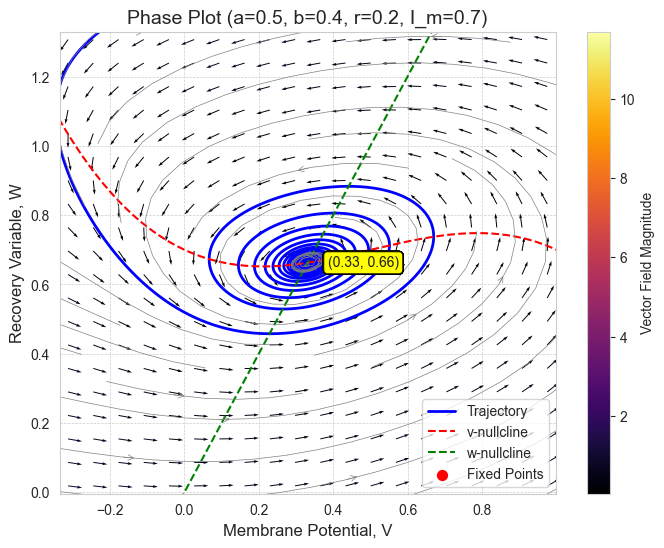

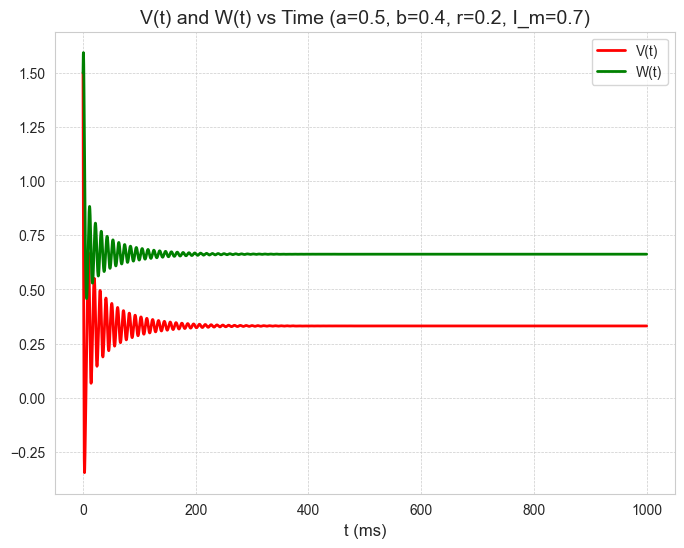

In [25]:
model.run_simulation(v0 = 01.5, w0=01.5, I_m =0.7,traj = True, scale=3 ,save=False, fp=True)